In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.fft import fft
from scipy.signal import welch
from scipy.stats import entropy, gmean
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# === Part 2: Model Development ===

# Suppress known numerical warnings (e.g., divide by zero, log of zero)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Parameters 
fs = 50
segment_size = 250
axes = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Load and process all CSV files from harth/ 
folder_path = "./harth"
features_list = []
labels = []

# Helper method 
def spectral_centroid(freqs, psd):
    return np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

# Segment data into windows, Calculates frequency features for each 
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_path, filename))
        if 'label' not in df.columns:
            continue
        for start in range(0, len(df) - segment_size, segment_size):
            end = start + segment_size
            segment = df.iloc[start:end]
            features = {}
            for axis in axes:
                signal = segment[axis].to_numpy()
                fft_vals = fft(signal)
                fft_mag = np.abs(fft_vals[:segment_size // 2])
                freqs, psd = welch(signal, fs=fs)
                psd_sum = np.sum(psd)
                psd_norm = psd / psd_sum if psd_sum > 0 else np.zeros_like(psd)

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    features[f'{axis}_spectral_energy'] = np.sum(fft_mag ** 2)
                    features[f'{axis}_dominant_freq'] = freqs[np.argmax(np.abs(fft_vals))]
                    features[f'{axis}_frequency_variance'] = np.var(psd)
                    features[f'{axis}_spectral_centroid'] = spectral_centroid(freqs, psd)
                    features[f'{axis}_spectral_entropy'] = entropy(psd_norm)
                    features[f'{axis}_spectral_flatness'] = gmean(psd + 1e-12) / (np.mean(psd) + 1e-12)
                    features[f'{axis}_peak_freq'] = freqs[np.argmax(psd)]
                    features[f'{axis}_bandwidth'] = (
                        np.sqrt(np.sum(psd * (freqs - spectral_centroid(freqs, psd))**2) / psd_sum)
                        if psd_sum > 0 else 0
                    )

                for i in range(5):
                    features[f'{axis}_fft_coef_{i}'] = fft_mag[i] if i < len(fft_mag) else 0

            features_list.append(features)
            labels.append(segment['label'].mode()[0])

X = pd.DataFrame(features_list)
y = pd.Series(labels)

In [3]:
# Impute + Split Data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Train each model 
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)



=== Decision Tree ===
Test Accuracy: 0.9101
Macro F1 Score: 0.7237
Micro F1 Score: 0.9101


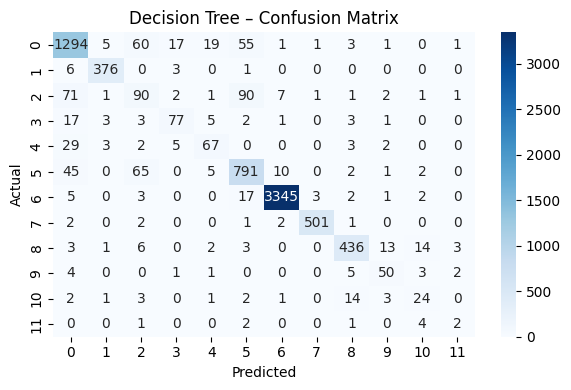

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.89      0.88      1457
           2       0.96      0.97      0.97       386
           3       0.38      0.34      0.36       268
           4       0.73      0.69      0.71       112
           5       0.66      0.60      0.63       111
           6       0.82      0.86      0.84       921
           7       0.99      0.99      0.99      3378
           8       0.99      0.98      0.99       509
          13       0.93      0.91      0.92       481
          14       0.68      0.76      0.71        66
         130       0.48      0.47      0.48        51
         140       0.22      0.20      0.21        10

    accuracy                           0.91      7750
   macro avg       0.73      0.72      0.72      7750
weighted avg       0.91      0.91      0.91      7750


=== K-Nearest Neighbors ===
Test Accuracy: 0.9105
Macro F1 Score: 0.7138
Micro F1 Score: 0.9105


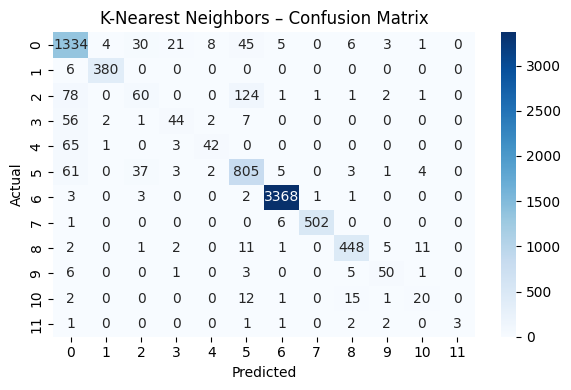

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.92      0.87      1457
           2       0.98      0.98      0.98       386
           3       0.45      0.22      0.30       268
           4       0.59      0.39      0.47       112
           5       0.78      0.38      0.51       111
           6       0.80      0.87      0.83       921
           7       0.99      1.00      1.00      3378
           8       1.00      0.99      0.99       509
          13       0.93      0.93      0.93       481
          14       0.78      0.76      0.77        66
         130       0.53      0.39      0.45        51
         140       1.00      0.30      0.46        10

    accuracy                           0.91      7750
   macro avg       0.81      0.68      0.71      7750
weighted avg       0.90      0.91      0.90      7750


=== Support Vector Machine ===
Test Accuracy: 0.8837
Macro F1 Score: 0.5176
Micro F1 Score: 0.8837


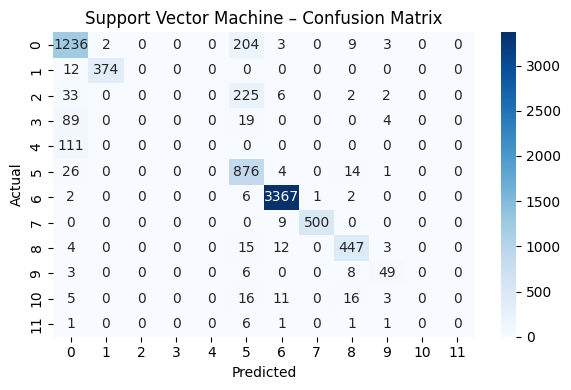

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.85      0.83      1457
           2       0.99      0.97      0.98       386
           3       0.00      0.00      0.00       268
           4       0.00      0.00      0.00       112
           5       0.00      0.00      0.00       111
           6       0.64      0.95      0.76       921
           7       0.99      1.00      0.99      3378
           8       1.00      0.98      0.99       509
          13       0.90      0.93      0.91       481
          14       0.74      0.74      0.74        66
         130       0.00      0.00      0.00        51
         140       0.00      0.00      0.00        10

    accuracy                           0.88      7750
   macro avg       0.51      0.53      0.52      7750
weighted avg       0.84      0.88      0.86      7750


=== Random Forest ===
Test Accuracy: 0.9388
Macro F1 Score: 0.7682
Micro F1 Score: 0.9388


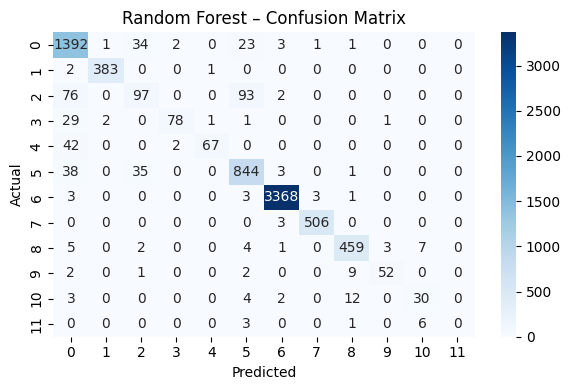

Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.96      0.91      1457
           2       0.99      0.99      0.99       386
           3       0.57      0.36      0.44       268
           4       0.95      0.70      0.80       112
           5       0.97      0.60      0.74       111
           6       0.86      0.92      0.89       921
           7       1.00      1.00      1.00      3378
           8       0.99      0.99      0.99       509
          13       0.95      0.95      0.95       481
          14       0.93      0.79      0.85        66
         130       0.70      0.59      0.64        51
         140       0.00      0.00      0.00        10

    accuracy                           0.94      7750
   macro avg       0.82      0.74      0.77      7750
weighted avg       0.93      0.94      0.93      7750



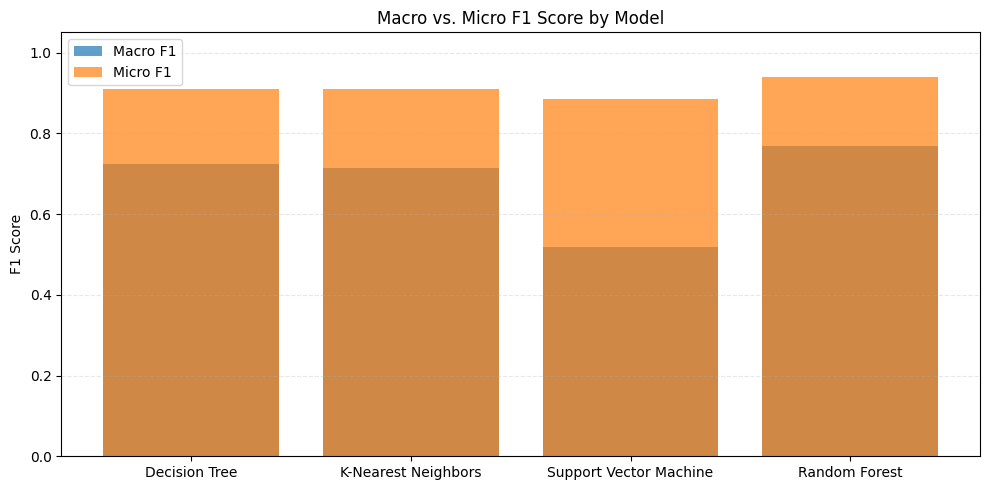


=== Model Comparison ===
                 Model  Test Accuracy
         Random Forest       0.938839
   K-Nearest Neighbors       0.910452
         Decision Tree       0.910065
Support Vector Machine       0.883742


In [4]:

# === Part 3: Model Evaluation on Test Data ===


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

macro_f1_scores = []
micro_f1_scores = []
results = []


for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    micro_f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
    macro_f1_scores.append((name, macro_f1))
    micro_f1_scores.append((name, micro_f1))

    print(f"\n=== {name} ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    results.append((name, acc))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

# --- Plot Macro and Micro F1 Scores ---
macro_df = pd.DataFrame(macro_f1_scores, columns=["Model", "Macro F1"])
micro_df = pd.DataFrame(micro_f1_scores, columns=["Model", "Micro F1"])

plt.figure(figsize=(10, 5))
plt.bar(macro_df["Model"], macro_df["Macro F1"], label='Macro F1', alpha=0.7)
plt.bar(micro_df["Model"], micro_df["Micro F1"], label='Micro F1', alpha=0.7)
plt.ylim(0, 1.05)
plt.ylabel("F1 Score")
plt.title("Macro vs. Micro F1 Score by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Print Accuracy Summary ---
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy"]).sort_values(by="Test Accuracy", ascending=False)
print("\n=== Model Comparison ===")
print(results_df.to_string(index=False))


In [5]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
print("\n=== 10-Fold Cross-Validation ===")
for name, model in models.items():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_validate(model, X_imputed, y, cv=10, scoring=scoring)
        print(f"\n=== {name} ===")
        print(f"Accuracy : {scores['test_accuracy'].mean():.4f}")
        print(f"Precision: {scores['test_precision_macro'].mean():.4f}")
        print(f"Recall   : {scores['test_recall_macro'].mean():.4f}")
        print(f"F1 Score : {scores['test_f1_macro'].mean():.4f}")


=== 10-Fold Cross-Validation ===

=== Decision Tree ===
Accuracy : 0.8944
Precision: 0.6591
Recall   : 0.6563
F1 Score : 0.6540

=== K-Nearest Neighbors ===
Accuracy : 0.8864
Precision: 0.6678
Recall   : 0.6017
F1 Score : 0.6117

=== Support Vector Machine ===
Accuracy : 0.8921
Precision: 0.5103
Recall   : 0.5313
F1 Score : 0.5160

=== Random Forest ===
Accuracy : 0.9350
Precision: 0.7929
Recall   : 0.6996
F1 Score : 0.7269
